# Style Transfer with CycleGAN


We will be implementing [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), which became extremely popular when it was published. Some portions of the code were directly lifted from the simplified implementation in https://github.com/yunjey/mnist-svhn-transfer

# Dataset Preparation

In [ ]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
import numpy as np
import random
import os

batch_size=64

transform = transforms.Compose([
                transforms.Resize(32),
                transforms.ToTensor(),])

#os.mkdir('data')

svhn = datasets.SVHN(root='data/', download=True, transform=transform)
mnist = datasets.MNIST(root='data/', download=True, transform=transform)

svhn_loader = torch.utils.data.DataLoader(dataset=svhn,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2,
                                          drop_last=True)

mnist_loader = torch.utils.data.DataLoader(dataset=mnist,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2,
                                           drop_last=True)

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
SEED=2
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

Let us look at some of the samples in the dataset

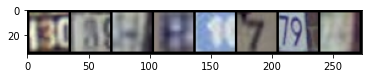

In [ ]:
import matplotlib.pyplot as plt

dataiter = iter(svhn_loader)
images, labels = next(dataiter)
img = images[:8]
img = torchvision.utils.make_grid(img) # this just compiles our data in a single image
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0))) # channel dimension is last
plt.show()

In [ ]:
img[0].min(), img[0].max()

(tensor(0.), tensor(0.9686))

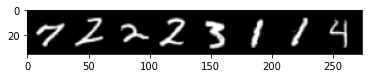

In [ ]:
dataiter = iter(mnist_loader)
images, labels = next(dataiter)
img = images[:8]
img = torchvision.utils.make_grid(img) # this just compiles our data in a single image
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0))) # channel dimension is last
plt.show()

In [ ]:
img[0].min(), img[0].max()

(tensor(0.), tensor(1.))

So our task is to make the "clean" MNIST samples look like a "real" image and make the "noisy" SVHN samples like MNIST.


# CycleGAN Network Components

First, we define the architecture. Our CycleGAN is composed of 4 components:
- MNIST to SVHN transformer 
- SVHN to MNIST transformer 
- MNIST discriminator
- SVHN discriminator

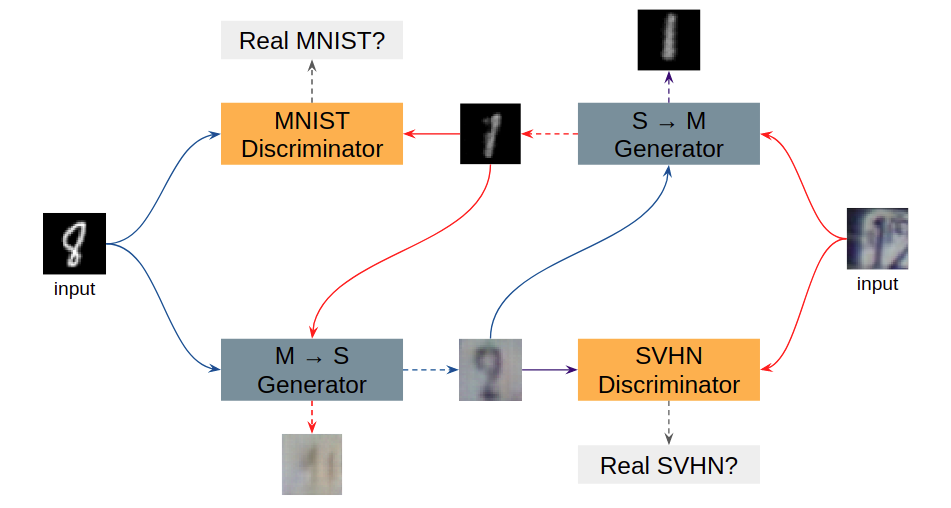

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, conv_dim=64):
        super(Generator, self).__init__()
        # encoder
        self.conv1 = nn.Conv2d(in_channels, conv_dim, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(conv_dim)
        self.conv2 = nn.Conv2d(conv_dim, conv_dim*2, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(conv_dim*2)
        self.conv3 = nn.Conv2d(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(conv_dim*2)
        self.conv4 = nn.Conv2d(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(conv_dim*2)

        # decoder
        self.deconv1 = nn.ConvTranspose2d(conv_dim*2, conv_dim, 4, 2, 1)
        self.bn5 = nn.BatchNorm2d(conv_dim)
        self.deconv2 = nn.ConvTranspose2d(conv_dim, out_channels, 4, 2, 1)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x))      # (-1, 64, 16, 16)
        out = self.bn1(out)
        out = F.leaky_relu(self.conv2(out))    # (-1, 128, 8, 8)
        out = self.bn2(out)
        out = F.leaky_relu(self.conv3(out))    # (-1, 128, 8, 8)
        out = self.bn3(out)
        out = F.leaky_relu(self.conv4(out))    # (-1, 128, 8, 8)
        out = self.bn4(out)

        out = F.leaky_relu(self.deconv1(out))  # (-1, 64, 16, 16)
        out = self.bn5(out)
        out = torch.sigmoid(self.deconv2(out))    # (-1, 3 or 1, 32, 32)
        return out


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, conv_dim=64):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, conv_dim, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(conv_dim, conv_dim*2, 4, 2, 1)
        self.conv3 = nn.Conv2d(conv_dim*2, conv_dim*2, 4, 2, 1)
        self.disc_out = nn.Conv2d(conv_dim*2, 1, 4, 1, 0)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x))    # (-1, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out))  # (-1, 128, 8, 8)
        out = F.leaky_relu(self.conv3(out))  # (-1, 128, 4, 4)
        out = self.disc_out(out).squeeze()
        return out

Let's initialize the network and define the optimizers. Take note that we have 2 optimizers with mutually exclusive set of parameters to optimize.

In [ ]:
from torch import optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

m2s = Generator(in_channels=1, out_channels=3).to(device)
s2m = Generator(in_channels=3, out_channels=1).to(device)
dm = Discriminator(in_channels=1).to(device)
ds = Discriminator(in_channels=3).to(device)

g_params = list(m2s.parameters()) + list(s2m.parameters())
d_params = list(dm.parameters()) + list(ds.parameters())

g_optimizer = optim.Adam(g_params, 1e-4, [0.5,0.999])
d_optimizer = optim.Adam(d_params, 2e-4, [0.5,0.999])

## Training the discriminator

We have two discriminators, one for SVHN and another for MNIST. The goal of these discriminators are to detect if the image is real or fake/translated.

We will define the discriminator loss as the MSE.

In [ ]:
def discriminator_loss(pred_dm, pred_ds, real_image):
    return torch.mean((pred_dm-real_image)**2) + torch.mean((pred_ds-real_image)**2)

def train_discriminator(svhn, mnist):
    dm.train()
    ds.train()
    s2m.train()
    m2s.train()

    g_optimizer.zero_grad()
    d_optimizer.zero_grad()

    fake_mnist = s2m(svhn)
    fake_svhn = m2s(mnist)

    mnist_ = torch.cat([mnist, fake_mnist], axis=0)
    svhn_ = torch.cat([svhn, fake_svhn], axis=0)

    pred_m = dm(mnist_)
    pred_s = ds(svhn_)
    d_real_loss = discriminator_loss(pred_m[:batch_size], pred_s[:batch_size], 1) # first half are real images
    d_fake_loss = discriminator_loss(pred_m[batch_size:], pred_s[batch_size:], 0) # second half are fake ones

    d_loss = d_real_loss + d_fake_loss
    d_loss.backward()
    d_optimizer.step()

    return d_real_loss, d_fake_loss

## Training the Generator



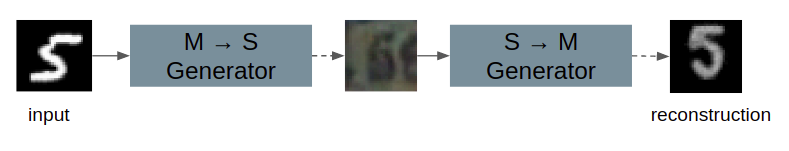

In [ ]:
def train_generator(svhn, mnist):
    dm.train()
    ds.train()
    s2m.train()
    m2s.train()

    g_optimizer.zero_grad()
    d_optimizer.zero_grad()

    fake_svhn = m2s(mnist)
    out = ds(fake_svhn)
    reconst_mnist = s2m(fake_svhn)

    mnist_g_loss = torch.mean((out-1)**2) # MSE
    mnist_recons_loss = torch.mean((mnist - reconst_mnist)**2)

    fake_mnist = s2m(svhn)
    out = dm(fake_mnist)
    reconst_svhn = m2s(fake_mnist)
    svhn_g_loss = torch.mean((out-1)**2) # MSE
    svhn_recons_loss = torch.mean((svhn - reconst_svhn)**2)

    g_loss = mnist_g_loss + mnist_recons_loss + svhn_g_loss + svhn_recons_loss
    g_loss.backward()
    g_optimizer.step()

    return g_loss

## Finally, we can define our training loop

In [ ]:
def train(svhn_loader, mnist_loader, train_iters):
    svhn_iter = iter(svhn_loader)
    mnist_iter = iter(mnist_loader)
    iter_per_epoch = min(len(svhn_iter), len(mnist_iter))

    # Select some random samples for visual validation since we do not have a test set
    fixed_svhn = next(svhn_iter)[0].to(device)
    fixed_mnist = next(mnist_iter)[0].to(device)


    for step in range(train_iters+1):

        # reset data_iter for each epoch
        if (step+1) % iter_per_epoch == 0:
            mnist_iter = iter(mnist_loader)
            svhn_iter = iter(svhn_loader)

        # load svhn and mnist dataset
        svhn, s_labels = next(svhn_iter)
        svhn = svhn.to(device)
        mnist, m_labels = next(mnist_iter)
        mnist = mnist.to(device)

        # Train step
        d_real_loss, d_fake_loss = train_discriminator(svhn, mnist)
        g_loss = train_generator(svhn, mnist)

        # print the log info
        if (step+1) % 200 == 0:
            print('Step [%d/%d], d_real_loss: %.4f, '
                  'd_fake_loss: %.4f, g_loss: %.4f'
                  %(step+1, train_iters, d_real_loss.item(), d_fake_loss.item(), g_loss.item()))

    # for visual inspection
    s2m.eval()
    m2s.eval()
    fake_svhn = m2s(fixed_mnist)
    fake_mnist = s2m(fixed_svhn)
    vis_m2s = make_grid(fixed_mnist, fake_svhn)
    vis_s2m = make_grid(fixed_svhn, fake_mnist)

    return fake_mnist, fake_svhn, vis_m2s, vis_s2m

In [ ]:
def make_grid(sources, targets, k=10):
    if sources.shape[1] == 1:
        sources = torch.repeat_interleave(sources, 3, 1)
    if targets.shape[1] == 1:
        targets = torch.repeat_interleave(targets, 3, 1)
    #target += 1
    b,_,h,w = sources.shape
    img = torch.cat([sources.unsqueeze(1), targets.unsqueeze(1)], axis=1)
    img = img.view(2*b,3,h,w)
    img = torchvision.utils.make_grid(img).cpu().detach()#.numpy().transpose(1,2,0)
    return transforms.ToPILImage()(img).convert("RGB")

In [ ]:
fake_mnist, fake_svhn, vis_m2s, vis_s2m = train(svhn_loader, mnist_loader, 30000)

Step [200/30000], d_real_loss: 0.2213, d_fake_loss: 0.3862, g_loss: 1.2560
Step [400/30000], d_real_loss: 0.5465, d_fake_loss: 0.6053, g_loss: 1.5303
Step [600/30000], d_real_loss: 0.3852, d_fake_loss: 0.3481, g_loss: 0.8823
Step [800/30000], d_real_loss: 0.2449, d_fake_loss: 0.5015, g_loss: 1.1062
Step [1000/30000], d_real_loss: 0.2877, d_fake_loss: 0.5167, g_loss: 0.9640
Step [1200/30000], d_real_loss: 0.3998, d_fake_loss: 0.3361, g_loss: 0.6959
Step [1400/30000], d_real_loss: 0.4500, d_fake_loss: 0.3429, g_loss: 0.8519
Step [1600/30000], d_real_loss: 0.4164, d_fake_loss: 0.2873, g_loss: 0.8480
Step [1800/30000], d_real_loss: 0.3906, d_fake_loss: 0.3286, g_loss: 0.9270
Step [2000/30000], d_real_loss: 0.2809, d_fake_loss: 0.3453, g_loss: 1.0211
Step [2200/30000], d_real_loss: 0.2359, d_fake_loss: 0.5295, g_loss: 1.4232
Step [2400/30000], d_real_loss: 0.5519, d_fake_loss: 0.2557, g_loss: 0.6344
Step [2600/30000], d_real_loss: 0.3451, d_fake_loss: 0.3374, g_loss: 1.1082
Step [2800/30000

In [ ]:
svhn_iter = iter(svhn_loader)
mnist_iter = iter(mnist_loader)
iter_per_epoch = min(len(svhn_iter), len(mnist_iter))

# Select some random samples fir visual validation
fixed_svhn = next(svhn_iter)[0].to(device)
fixed_mnist = next(mnist_iter)[0].to(device)

s2m.eval()
m2s.eval()
fake_svhn = m2s(fixed_mnist)
fake_mnist = s2m(fixed_svhn)

mergedm2s = make_grid(fixed_mnist, fake_svhn)
mergeds2m = make_grid(fixed_svhn, fake_mnist)

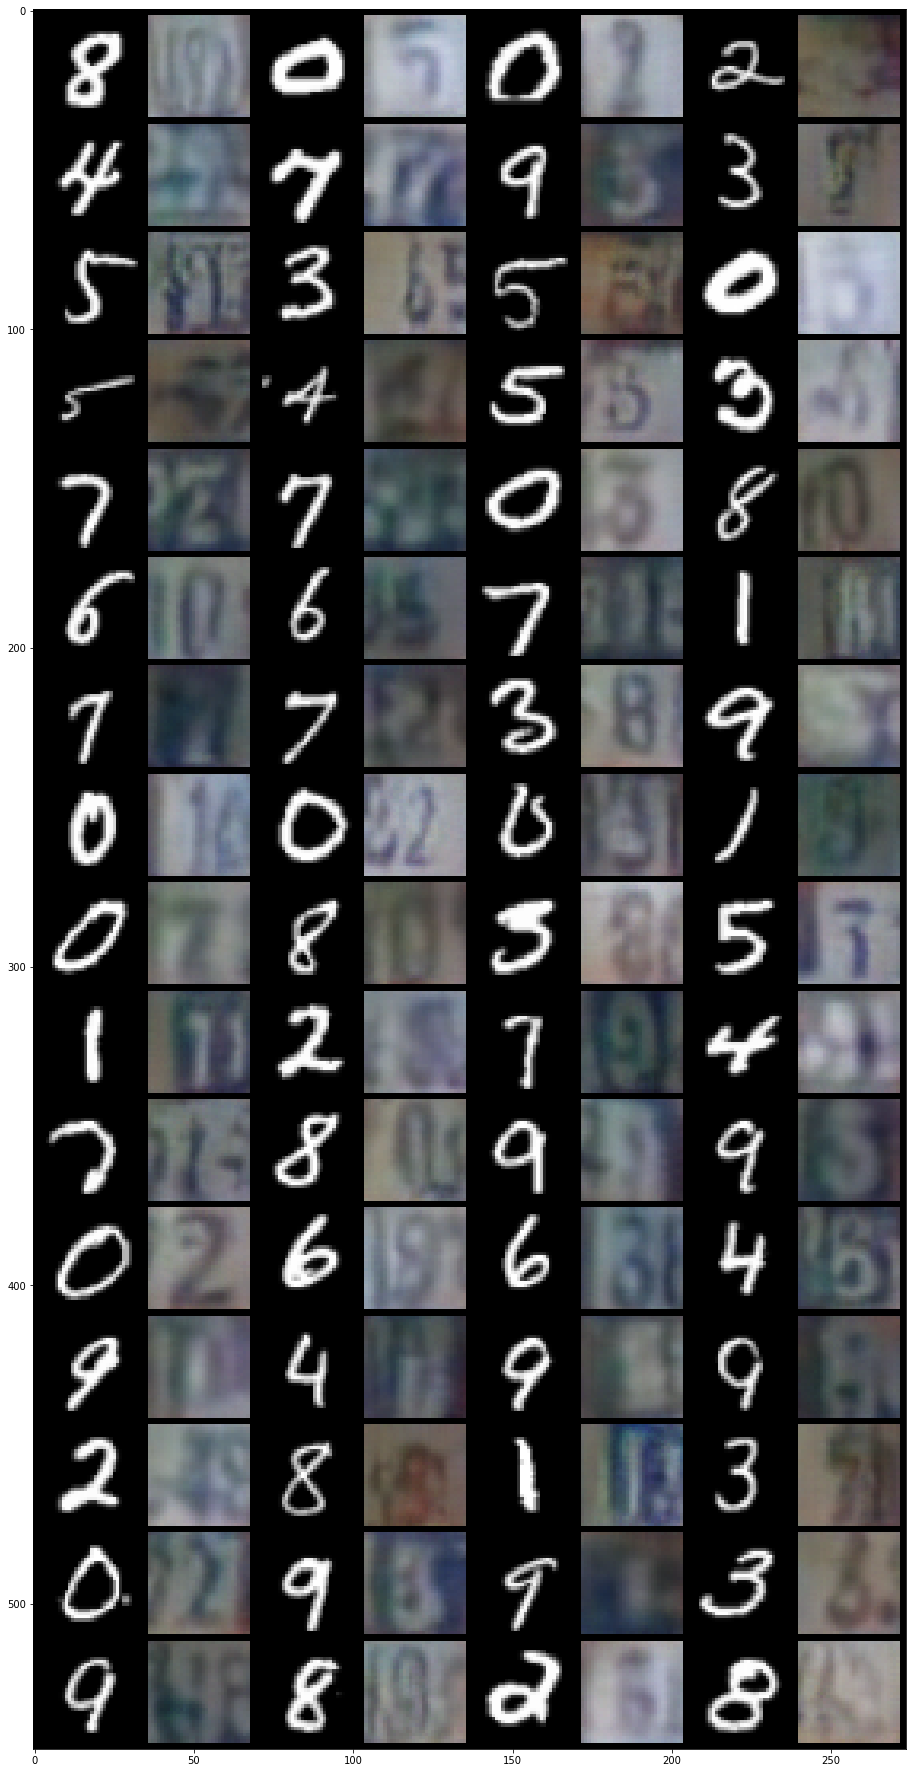

In [ ]:
plt.figure(figsize=(8*2,16*2))
plt.imshow(mergedm2s)

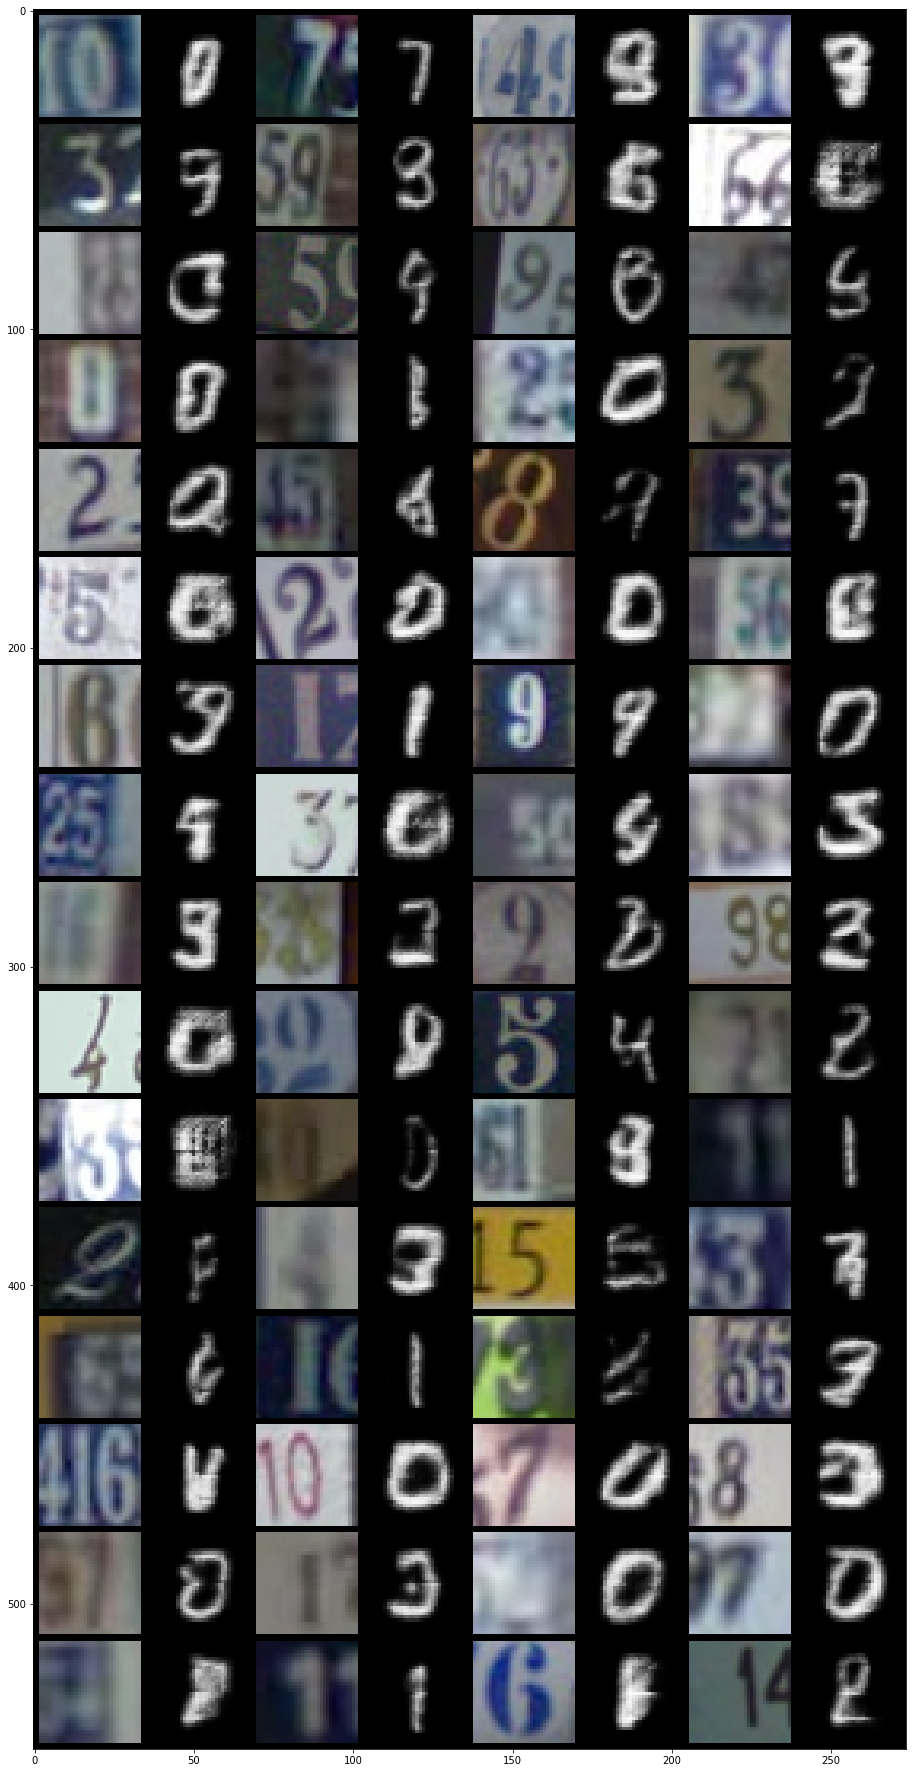

In [ ]:
plt.figure(figsize=(8*2,16*2))
plt.imshow(mergeds2m)

As you can see, many samples from SVHN were translated to MNIST-style as "1". This is possibly because the generator could confuse the discriminator easily with that. This is called the mode collapse problem. In some cases, you just need to give weights to the different components of the generator's loss function (maybe more weight to the cycle consistency loss). Another possible solution is utilizing the labels as described [here](https://colab.research.google.com/drive/1b5jUPAXXe0Jknti80PLcTPG8Wb0HXXoe?usp=sharing).